In [10]:
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization, GlobalAveragePooling2D, Activation
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from sklearn.utils import class_weight
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2




In [15]:
# Define parameters
batch_size = 64
img_height, img_width = 150, 150
num_classes = 9
epochs = 10

In [71]:
import glob
from pathlib import Path


dataset_dir = r"C:\old stuff\Desktop\CSM422\realwastedataset"
# image_paths = []
# labels = []

# for class_folder in os.listdir(dataset_dir):
#     class_path = os.path.join(dataset_dir, class_folder)
#     if os.path.isdir(class_path):
#         for img_file in glob.glob(os.path.join(class_path, "*.jpg")):  # Or ".png", ".jpeg"
#             image_paths.append(img_file)
#             labels.append(class_folder)

# # Convert to NumPy arrays for easier manipulation
# image_paths = np.array(image_paths)
# labels = np.array(labels)


In [16]:


# Path to the directory containing all images (organized into subdirectories by class)
data_dir = r"C:\old stuff\Desktop\CSM422\realwastedataset"
 
file_paths = []
labels = []
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            file_paths.append(os.path.join(class_path, img_file))
            labels.append(class_name)



In [17]:
# Split file paths and labels into train and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=42
)




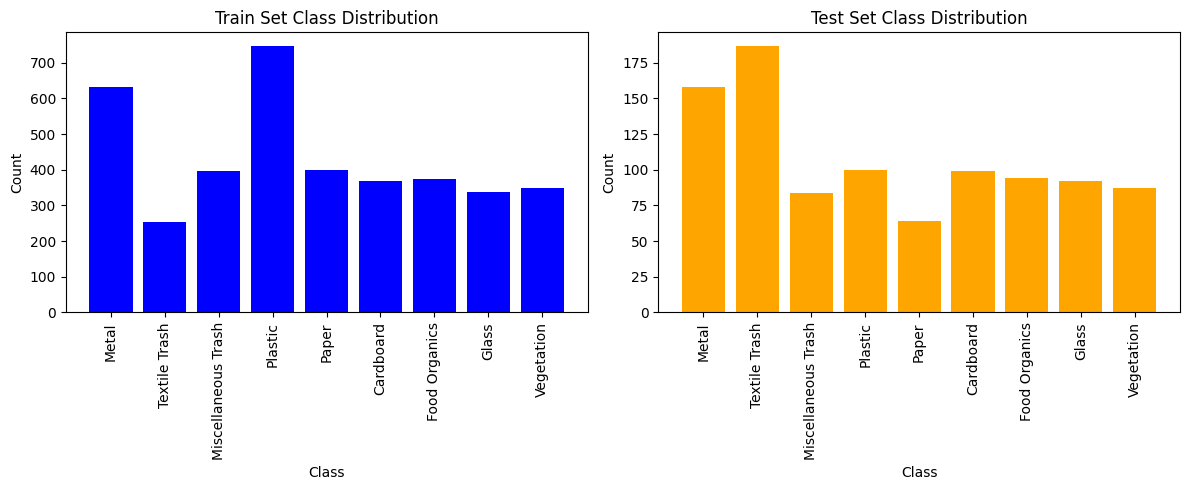

In [18]:
import matplotlib.pyplot as plt
from collections import Counter
# Count class occurrences in train and test labels
train_class_counts = Counter(train_labels)
test_class_counts = Counter(test_labels)
# Extract class labels and counts for plotting
classes = list(train_class_counts.keys())
train_counts = list(train_class_counts.values())
test_counts = list(test_class_counts.values())
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# Train set distribution
ax[0].bar(classes, train_counts, color='blue')
ax[0].set_title('Train Set Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')
ax[0].set_xticks(classes)
ax[0].set_xticklabels(classes, rotation=90)  # Rotate x-tick labels if needed
# Test set distribution
ax[1].bar(classes, test_counts, color='orange')
ax[1].set_title('Test Set Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')
ax[1].set_xticks(classes)
ax[1].set_xticklabels(classes, rotation=90)  # Rotate x-tick labels if needed
plt.tight_layout()
plt.show()


In [19]:
# Helper function to create a data generator from file paths and labels
def create_generator(file_paths, labels, batch_size=64, img_size=(150, 150)):
    data_gen = ImageDataGenerator(rescale=1.0 / 255)
    return data_gen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': file_paths, 'class': labels}),
        x_col='filename',
        y_col='class',
        target_size=img_size,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True
    )


In [20]:

# Create train and test generators
train_generator = create_generator(train_paths, train_labels)
test_generator = create_generator(test_paths, test_labels)

Found 3860 validated image filenames belonging to 9 classes.
Found 965 validated image filenames belonging to 9 classes.


In [77]:
class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)

Class names: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


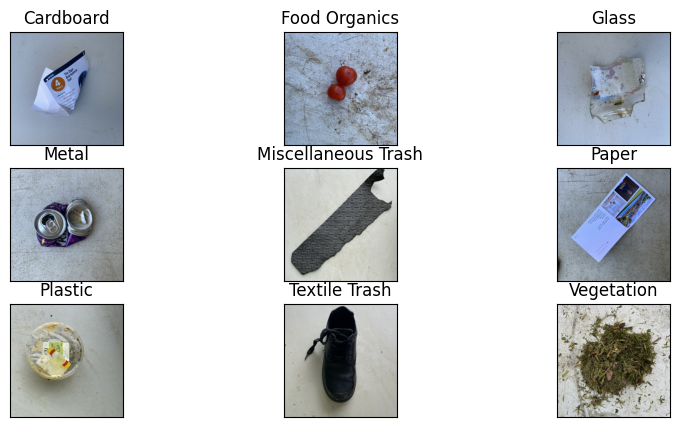

In [78]:
# Display one sample image per class
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(10, 5))
for i, class_name in enumerate(class_names):
    # Find all indices for images belonging to the current class
    class_indices = [idx for idx, label in enumerate(train_generator.classes) if label == i]
    
    # Randomly select one index for the current class
    img_index = np.random.choice(class_indices)
    
    # Load the image and display it
    img_path = train_generator.filepaths[img_index]
    img = plt.imread(img_path)
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.set_title(class_name)
    plt.imshow(img)

plt.show()


In [79]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2

# Load the VGG16 model
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model
base_model_vgg.trainable = False

# Create the model
model_vgg = Sequential([
    base_model_vgg,
    Flatten(),
    Dense(512, activation='relu'), 
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
print(model_vgg.summary())


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,914,121 (72.15 MB)

 Trainable params: 4,199,433 (16.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [80]:
batch = next(train_generator)
print(f"Images batch shape: {batch[0].shape}")
print(f"Labels batch shape: {batch[1].shape}")


Images batch shape: (64, 150, 150, 3)
Labels batch shape: (64, 9)


In [21]:
from sklearn.utils.class_weight import compute_class_weight
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_encoded),
    y=train_labels_encoded
)
class_weights = dict(enumerate(class_weights))

# Update your create_generator function to use integer labels
def create_generator(file_paths, labels, batch_size=64, img_size=(150, 150)):
    data_gen = ImageDataGenerator(rescale=1.0 / 255)
    return data_gen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': file_paths, 'class': labels}),
        x_col='filename',
        y_col='class',
        target_size=img_size,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True
    )


# Wrap the train generator as a tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(label_encoder.classes_)), dtype=tf.float32)
    )
)


In [82]:
history_vgg = model_vgg.fit(
    train_dataset,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
     class_weight=class_weights
)



Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2922 - loss: 2.3314

c:\old stuff\Desktop\CSM422\.conda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 234s 4s/step - accuracy: 0.2940 - loss: 2.3219 - val_accuracy: 0.5802 - val_loss: 1.1775
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.5711 - loss: 1.1540 - val_accuracy: 0.6000 - val_loss: 0.9017
Epoch 3/20


c:\old stuff\Desktop\CSM422\.conda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


60/60 ━━━━━━━━━━━━━━━━━━━━ 236s 4s/step - accuracy: 0.6564 - loss: 0.9284 - val_accuracy: 0.6771 - val_loss: 0.9102
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.6979 - loss: 0.8208 - val_accuracy: 0.2000 - val_loss: 1.5556
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 229s 4s/step - accuracy: 0.7172 - loss: 0.7569 - val_accuracy: 0.7208 - val_loss: 0.8382
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.7625 - loss: 0.6542 - val_accuracy: 0.8000 - val_loss: 0.5806
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 239s 4s/step - accuracy: 0.7578 - loss: 0.6253 - val_accuracy: 0.7177 - val_loss: 0.7846
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 182s 3s/step - accuracy: 0.7989 - loss: 0.5538 - val_accuracy: 0.8000 - val_loss: 0.4254
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 235s 4s/step - accuracy: 0.8281 - loss: 0.4563 - val_accuracy: 0.7365 - val_loss: 0.7787
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 190s 3s/step - accuracy: 0.8406 - loss: 0.4200 - val_accuracy: 0.8000 - val_loss: 0

In [ ]:
# Print the test accuracy Of CNN Model1 
test_loss, test_accuracy = model_vgg.evaluate(test_generator)
# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.7946 - loss: 0.7011
Test Accuracy: 75.65%


In [86]:
import json
# Save the history
with open('history_vgg.json', 'w') as f:
    json.dump(history_vgg.history, f)
    
model_vgg.save('model_vgg.h5')    

In [7]:
import json
with open('history_vgg.json', 'r') as f:
    history_vgg = json.load(f)

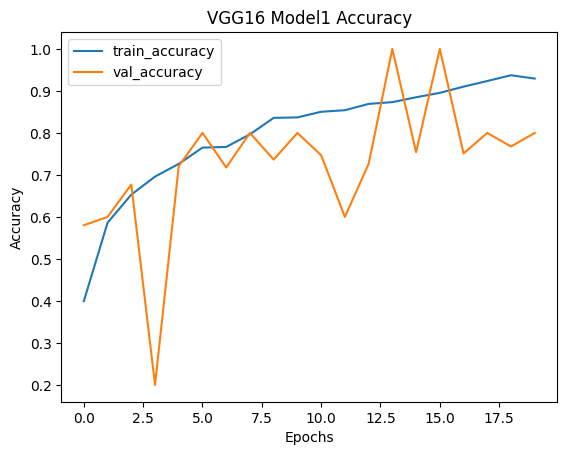

In [11]:
# Visualize Training History for VGG16
plt.plot(history_vgg['accuracy'], label='train_accuracy')
plt.plot(history_vgg['val_accuracy'], label='val_accuracy')
plt.title('VGG16 Model1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

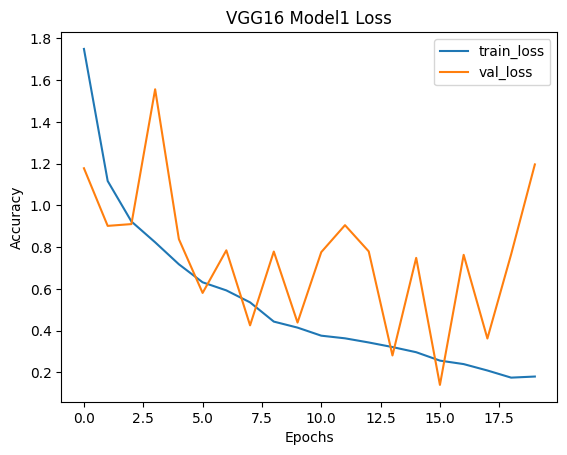

In [12]:
# Visualize Training History for VGG16
plt.plot(history_vgg['loss'], label='train_loss')
plt.plot(history_vgg['val_loss'], label='val_loss')
plt.title('VGG16 Model1 Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
from keras.models import load_model

# Load the model from an H5 file
model_path = 'model_vgg.h5'  # Replace with your model file path
model_vgg = load_model(model_path)

c:\old stuff\Desktop\CSM422\.conda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step
Classification Report:

                     precision    recall  f1-score   support

          Cardboard       0.10      0.09      0.09        92
      Food Organics       0.12      0.13      0.12        94
              Glass       0.09      0.10      0.09        84
              Metal       0.21      0.22      0.22       158
Miscellaneous Trash       0.18      0.14      0.16        99
              Paper       0.10      0.10      0.10       100
            Plastic       0.21      0.23      0.22       187
      Textile Trash       0.09      0.09      0.09        64
         Vegetation       0.11      0.10      0.11        87

           accuracy                           0.15       965
          macro avg       0.13      0.13      0.13       965
       weighted avg       0.15      0.15      0.15       965

Confusion matrix:

[[ 8 19 12 15  5  9 13  3  8]
 [10 12 13 13  7  9 15  9  6]
 [ 4 16  8 15  8  3 22  3  5]
 [ 9 17 16 35  8 19 29 14 11]
 [

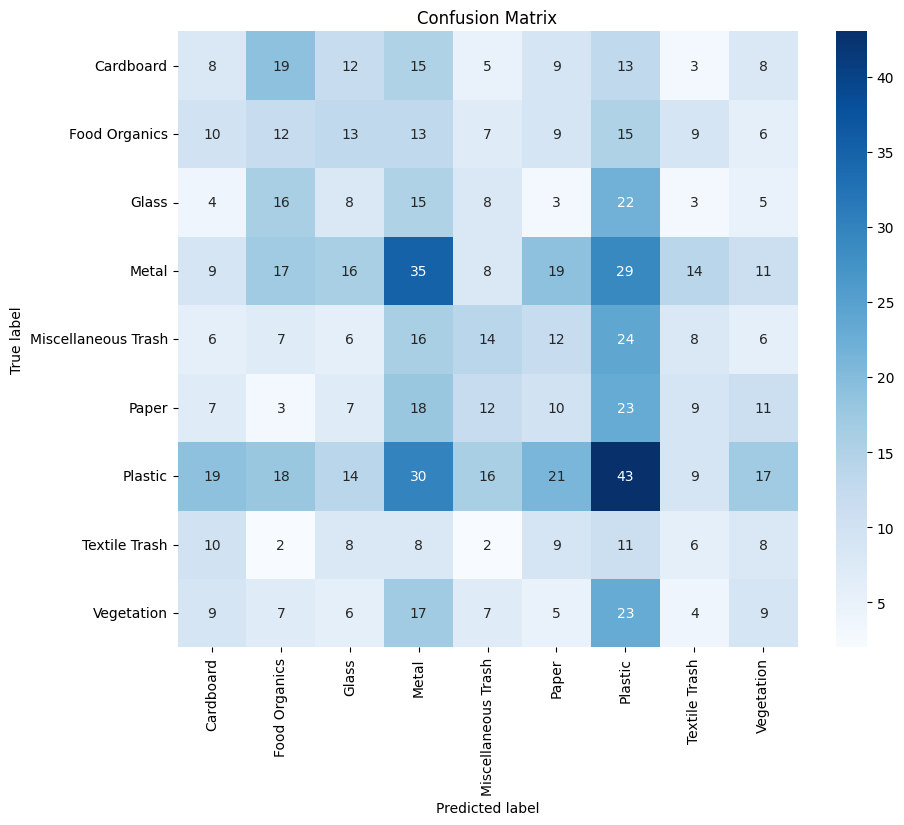

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = test_generator.classes
# Get the predicted labels
y_pred = np.argmax(model_vgg.predict(test_generator), axis=-1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

print("Confusion matrix:\n")
print(conf_matrix)
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=classes,
                yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(conf_matrix, classes=test_generator.class_indices.keys())


In [85]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import Adam

# Define a learning rate range to test
learning_rates = np.logspace(-6, 0, num=20)  # Range from 1e-6 to 1
losses = []

# Iterate over each learning rate
for lr in learning_rates:
    # Compile model with the current learning rate
    model_vgg.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Callback to save loss after each batch
    batch_loss = []

    def batch_end(batch, logs):
        batch_loss.append(logs['loss'])

    # Fit model for 1 epoch to track loss across different LRs
    model_vgg.fit(
        train_generator,
        epochs=1,
        steps_per_epoch=train_generator.samples // batch_size,
        callbacks=[LambdaCallback(on_batch_end=batch_end)]
    )
    
    # Store the average loss for this learning rate
    losses.append(np.mean(batch_loss))

# Plot loss vs. learning rate
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, losses)
plt.xscale('log')
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate Finder")
plt.show()


c:\old stuff\Desktop\CSM422\.conda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.9317 - loss: 0.2073
38/60 ━━━━━━━━━━━━━━━━━━━━ 1:09 3s/step - accuracy: 0.9212 - loss: 0.2032

KeyboardInterrupt: 

In [87]:

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Load and freeze the base model
base_model_vgg2 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
for layer in base_model_vgg2.layers[:-4]:  # Unfreeze only the last 4 layers
    layer.trainable = False

# Define the new model with added regularization
model_vgg2 = Sequential([
    base_model_vgg2,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),  # l2 regularization
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model with a low learning rate
model_vgg2.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])



In [88]:
# Data augmentation
train_data_gen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
train_generator = train_data_gen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_paths, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(150, 150),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)




Found 3860 validated image filenames belonging to 9 classes.


In [89]:
# Wrap the train generator as a tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(label_encoder.classes_)), dtype=tf.float32)
    )
)

In [90]:
# Learning rate reduction on plateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
# Train the model
history_vgg2 = model_vgg2.fit(
    train_dataset,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[reduce_lr],
    class_weight=class_weights
)

Epoch 1/20


60/60 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - accuracy: 0.2616 - loss: 2.0806 - val_accuracy: 0.5615 - val_loss: 1.2135 - learning_rate: 1.0000e-04
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 211s 4s/step - accuracy: 0.5457 - loss: 1.2443 - val_accuracy: 0.8000 - val_loss: 0.4498 - learning_rate: 1.0000e-04
Epoch 3/20


c:\old stuff\Desktop\CSM422\.conda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


60/60 ━━━━━━━━━━━━━━━━━━━━ 256s 4s/step - accuracy: 0.6468 - loss: 1.0059 - val_accuracy: 0.6562 - val_loss: 0.9866 - learning_rate: 1.0000e-04
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 222s 4s/step - accuracy: 0.6946 - loss: 0.9060 - val_accuracy: 0.4000 - val_loss: 0.9584 - learning_rate: 1.0000e-04
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - accuracy: 0.7298 - loss: 0.7942 - val_accuracy: 0.7365 - val_loss: 0.8251 - learning_rate: 1.0000e-04
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 227s 4s/step - accuracy: 0.7562 - loss: 0.6757 - val_accuracy: 1.0000 - val_loss: 0.1371 - learning_rate: 1.0000e-04
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 265s 4s/step - accuracy: 0.7842 - loss: 0.5702 - val_accuracy: 0.7771 - val_loss: 0.7057 - learning_rate: 1.0000e-04
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 220s 4s/step - accuracy: 0.8191 - loss: 0.5241 - val_accuracy: 0.6000 - val_loss: 1.2961 - learning_rate: 1.0000e-04
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 258s 4s/step - accuracy: 0.8226 - loss: 0.4

In [ ]:
# CNN Model2
test_loss, train_accuracy = model_vgg2.evaluate(train_generator)
test_loss, test_accuracy = model_vgg2.evaluate(test_generator)
# Print the test accuracy
print(f"Test Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

c:\old stuff\Desktop\CSM422\.conda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 ━━━━━━━━━━━━━━━━━━━━ 215s 4s/step - accuracy: 0.9720 - loss: 0.1464
16/16 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.8259 - loss: 0.6986
Test Accuracy: 97.20%
Test Accuracy: 82.59%


In [23]:
import json
with open('history_vgg2.json', 'r') as f:
    history_vgg2 = json.load(f)

In [24]:
from keras.models import load_model

# Load the model from an H5 file
model_path = 'model_vgg2.h5'  # Replace with your model file path
model_vgg2 = load_model(model_path)

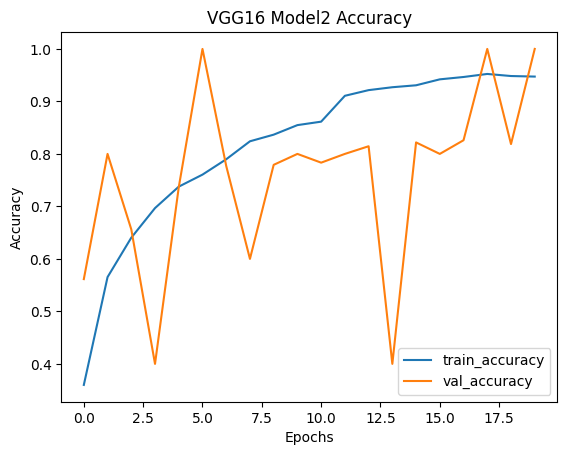

In [26]:
# Visualize Training History for VGG16
plt.plot(history_vgg2['accuracy'], label='train_accuracy')
plt.plot(history_vgg2['val_accuracy'], label='val_accuracy')
plt.title('VGG16 Model2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

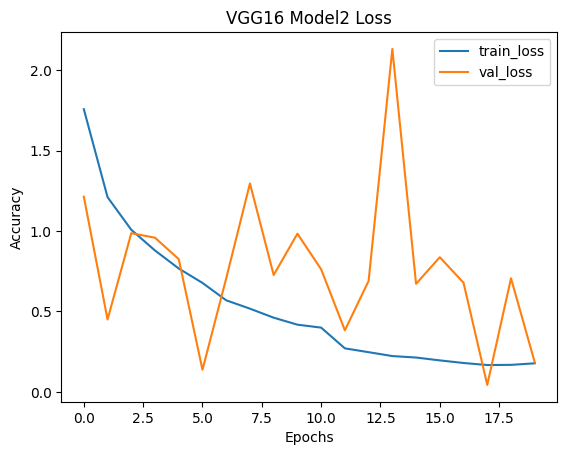

In [28]:
# Visualize Training History for VGG16
plt.plot(history_vgg2['loss'], label='train_loss')
plt.plot(history_vgg2['val_loss'], label='val_loss')
plt.title('VGG16 Model2 Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step
Classification Report:

                     precision    recall  f1-score   support

          Cardboard       0.14      0.17      0.16        92
      Food Organics       0.11      0.11      0.11        94
              Glass       0.13      0.13      0.13        84
              Metal       0.17      0.18      0.18       158
Miscellaneous Trash       0.09      0.08      0.08        99
              Paper       0.15      0.15      0.15       100
            Plastic       0.22      0.20      0.21       187
      Textile Trash       0.07      0.06      0.07        64
         Vegetation       0.11      0.11      0.11        87

           accuracy                           0.15       965
          macro avg       0.13      0.13      0.13       965
       weighted avg       0.15      0.15      0.14       965

Confusion matrix:

[[16  7  9 12 10  6 16  4 12]
 [ 6 10 11 12 12 10 17  7  9]
 [10  5 11 15  9  9 17  2  6]
 [17 18 13 29 12 15 25 12 17]
 [

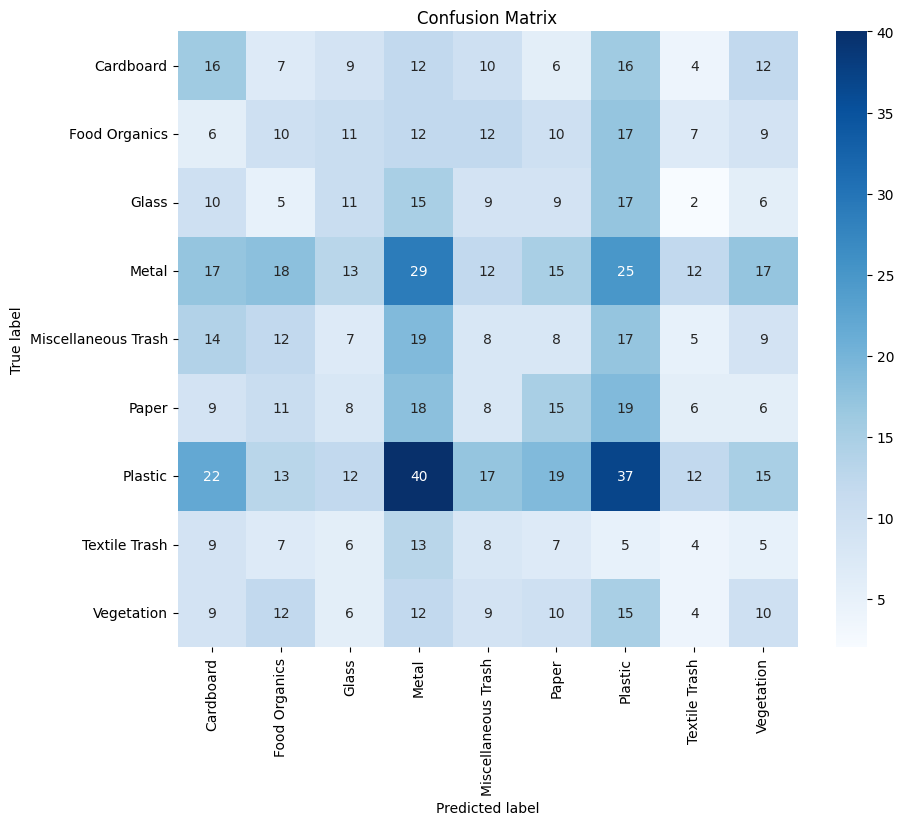

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = test_generator.classes
# Get the predicted labels
y_pred = np.argmax(model_vgg2.predict(test_generator), axis=-1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

print("Confusion matrix:\n")
print(conf_matrix)
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=classes,
                yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(conf_matrix, classes=test_generator.class_indices.keys())


In [93]:
import json
# Save the history
with open('history_vgg2.json', 'w') as f:
    json.dump(history_vgg2.history, f)

In [94]:
model_vgg2.save('model_vgg2.h5') 

In [ ]:
import json
import matplotlib.pyplot as plt

# Load the history from the JSON file
with open('history_vgg2.json', 'r') as f:
    history = json.load(f)

# Plotting Accuracy vs Validation Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss vs Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Load base model
base_model_vgg3 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_vgg3.trainable = False

# Unfreeze specific layers for fine-tuning
for layer in base_model_vgg3.layers[-8:]:
    layer.trainable = True

# Model definition with dropout and regularization
model_vgg3 = Sequential([
    base_model_vgg3,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.6),
    Dense(num_classes, activation='softmax')
])

from tensorflow.keras.optimizers.schedules import ExponentialDecay

initial_lr = 1e-4
lr_schedule = ExponentialDecay(initial_lr, decay_steps=10000, decay_rate=0.9, staircase=True)

# Use this schedule in the optimizer
model_vgg3.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Define data augmentation
train_data_gen3 = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

train_generator3 = train_data_gen3.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_paths, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

# Wrap the train generator as a tf.data.Dataset
train_dataset3 = tf.data.Dataset.from_generator(
    lambda: train_generator3,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(label_encoder.classes_)), dtype=tf.float32)
    )
)



Found 3860 validated image filenames belonging to 9 classes.


In [ ]:
test_generator3 = train_data_gen3.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_paths, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)


Found 965 validated image filenames belonging to 9 classes.


In [ ]:
batch = next(test_generator3)
print(f"Images batch shape: {batch[0].shape}")
print(f"Labels batch shape: {batch[1].shape}")

Images batch shape: (64, 224, 224, 3)
Labels batch shape: (64, 9)


In [ ]:
# Training the model
history_vgg3 = model_vgg3.fit(
    train_dataset3,
    steps_per_epoch=train_generator3.samples // batch_size,
    epochs=30,
    validation_data=test_generator3,
    validation_steps=test_generator3.samples // batch_size,
    class_weight=class_weights
)

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.2047 - loss: 2.1822 

c:\old stuff\Desktop\CSM422\.conda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 875s 15s/step - accuracy: 0.2057 - loss: 2.1793 - val_accuracy: 0.4177 - val_loss: 1.7066
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 766s 13s/step - accuracy: 0.4032 - loss: 1.6902 - val_accuracy: 1.0000 - val_loss: 0.3110
Epoch 3/30


c:\old stuff\Desktop\CSM422\.conda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


60/60 ━━━━━━━━━━━━━━━━━━━━ 873s 15s/step - accuracy: 0.5119 - loss: 1.3684 - val_accuracy: 0.6344 - val_loss: 1.0718
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 776s 13s/step - accuracy: 0.6144 - loss: 1.0970 - val_accuracy: 0.8000 - val_loss: 1.1556
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 887s 15s/step - accuracy: 0.6663 - loss: 0.9707 - val_accuracy: 0.7219 - val_loss: 0.8472
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 719s 12s/step - accuracy: 0.6966 - loss: 0.8815 - val_accuracy: 0.6000 - val_loss: 0.5844
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 810s 14s/step - accuracy: 0.7214 - loss: 0.8054 - val_accuracy: 0.7229 - val_loss: 0.8533
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 706s 12s/step - accuracy: 0.7622 - loss: 0.6804 - val_accuracy: 0.4000 - val_loss: 2.0486
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 816s 14s/step - accuracy: 0.7812 - loss: 0.6373 - val_accuracy: 0.7750 - val_loss: 0.6710
Epoch 10/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 704s 12s/step - accuracy: 0.7799 - loss: 0.6249 - val_accuracy: 0.6000 - val

In [ ]:
import json
# Save the history
with open('history_vgg3.json', 'w') as f:
    json.dump(history_vgg3.history, f)

In [ ]:
model_vgg3.save('model_vgg3.h5')

In [ ]:
from tensorflow.keras.models import load_model
model_vgg3 = load_model('model_vgg3.h5')

In [ ]:
# CNN model of Final Model
test_loss, test_accuracy = model_vgg3.evaluate(test_generator3)
# print(f'Test accuracy: {train_accuracy:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

61/61 ━━━━━━━━━━━━━━━━━━━━ 478s 8s/step - accuracy: 0.9667 - loss: 0.1220
16/16 ━━━━━━━━━━━━━━━━━━━━ 114s 7s/step - accuracy: 0.8419 - loss: 0.6954
Test accuracy: 0.9661
Test accuracy: 0.8425


In [29]:
with open('history_vgg3.json', 'r') as f:
    history_vgg3 = json.load(f)

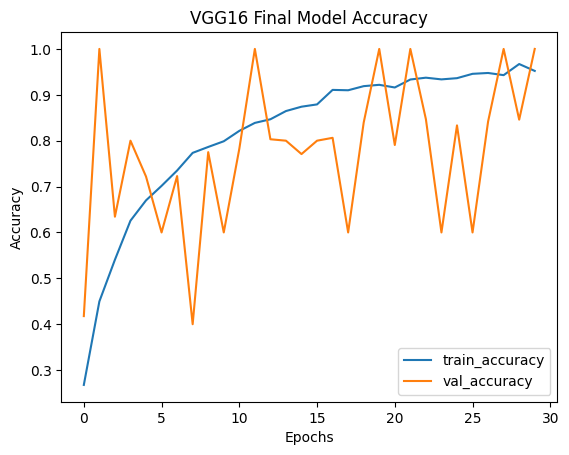

In [30]:
# Visualize Training History for VGG16
plt.plot(history_vgg3['accuracy'], label='train_accuracy')
plt.plot(history_vgg3['val_accuracy'], label='val_accuracy')
plt.title('VGG16 Final Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

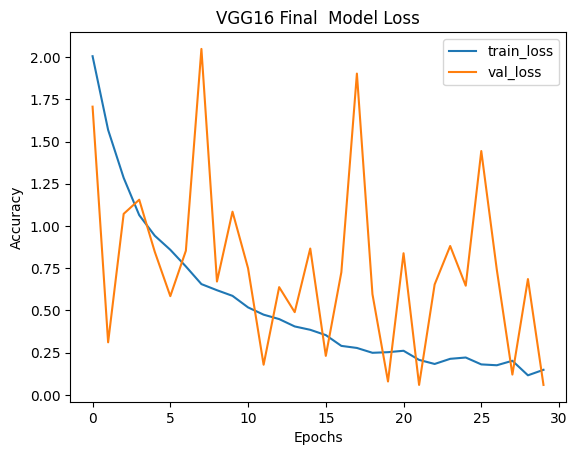

In [31]:
# Visualize Training History for VGG16
plt.plot(history_vgg3['loss'], label='train_loss')
plt.plot(history_vgg3['val_loss'], label='val_loss')
plt.title('VGG16 Final  Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 123s 8s/step
Classification Report:

                     precision    recall  f1-score   support

          Cardboard       0.12      0.11      0.12        92
      Food Organics       0.17      0.18      0.17        94
              Glass       0.09      0.10      0.09        84
              Metal       0.18      0.14      0.16       158
Miscellaneous Trash       0.13      0.12      0.12        99
              Paper       0.08      0.10      0.09       100
            Plastic       0.17      0.18      0.18       187
      Textile Trash       0.04      0.03      0.03        64
         Vegetation       0.05      0.05      0.05        87

           accuracy                           0.12       965
          macro avg       0.11      0.11      0.11       965
       weighted avg       0.12      0.12      0.12       965

Confusion matrix:

[[10 11 11  7  5 12 20  3 13]
 [ 5 17  7  8 10 15 20  4  8]
 [ 5  3  8  8  7 16 26  5  6]
 [16 14 11 22 21 23 29 13  9]
 

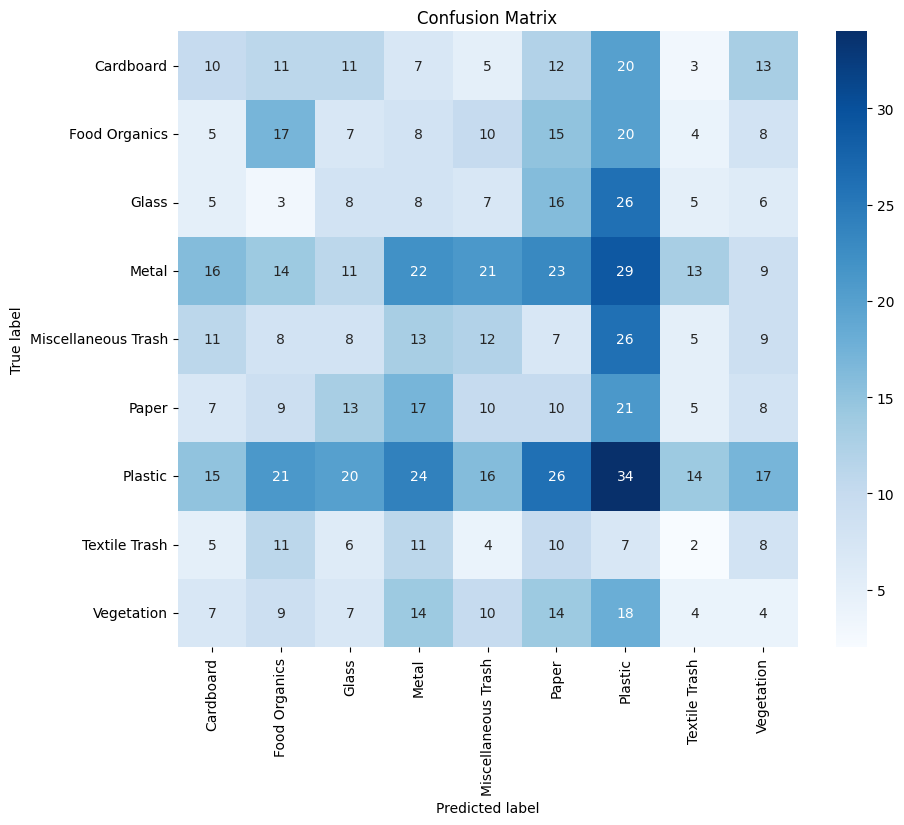

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Assuming test_generator is your test data generator
# Get the true labels from the test generator
y_true = test_generator.classes
# Get the predicted labels
y_pred = np.argmax(model_vgg3.predict(test_generator3), axis=-1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
print("Confusion matrix:\n")
print(conf_matrix)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=classes,
                yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot the confusion matrix
plot_confusion_matrix(conf_matrix, classes=test_generator.class_indices.keys())


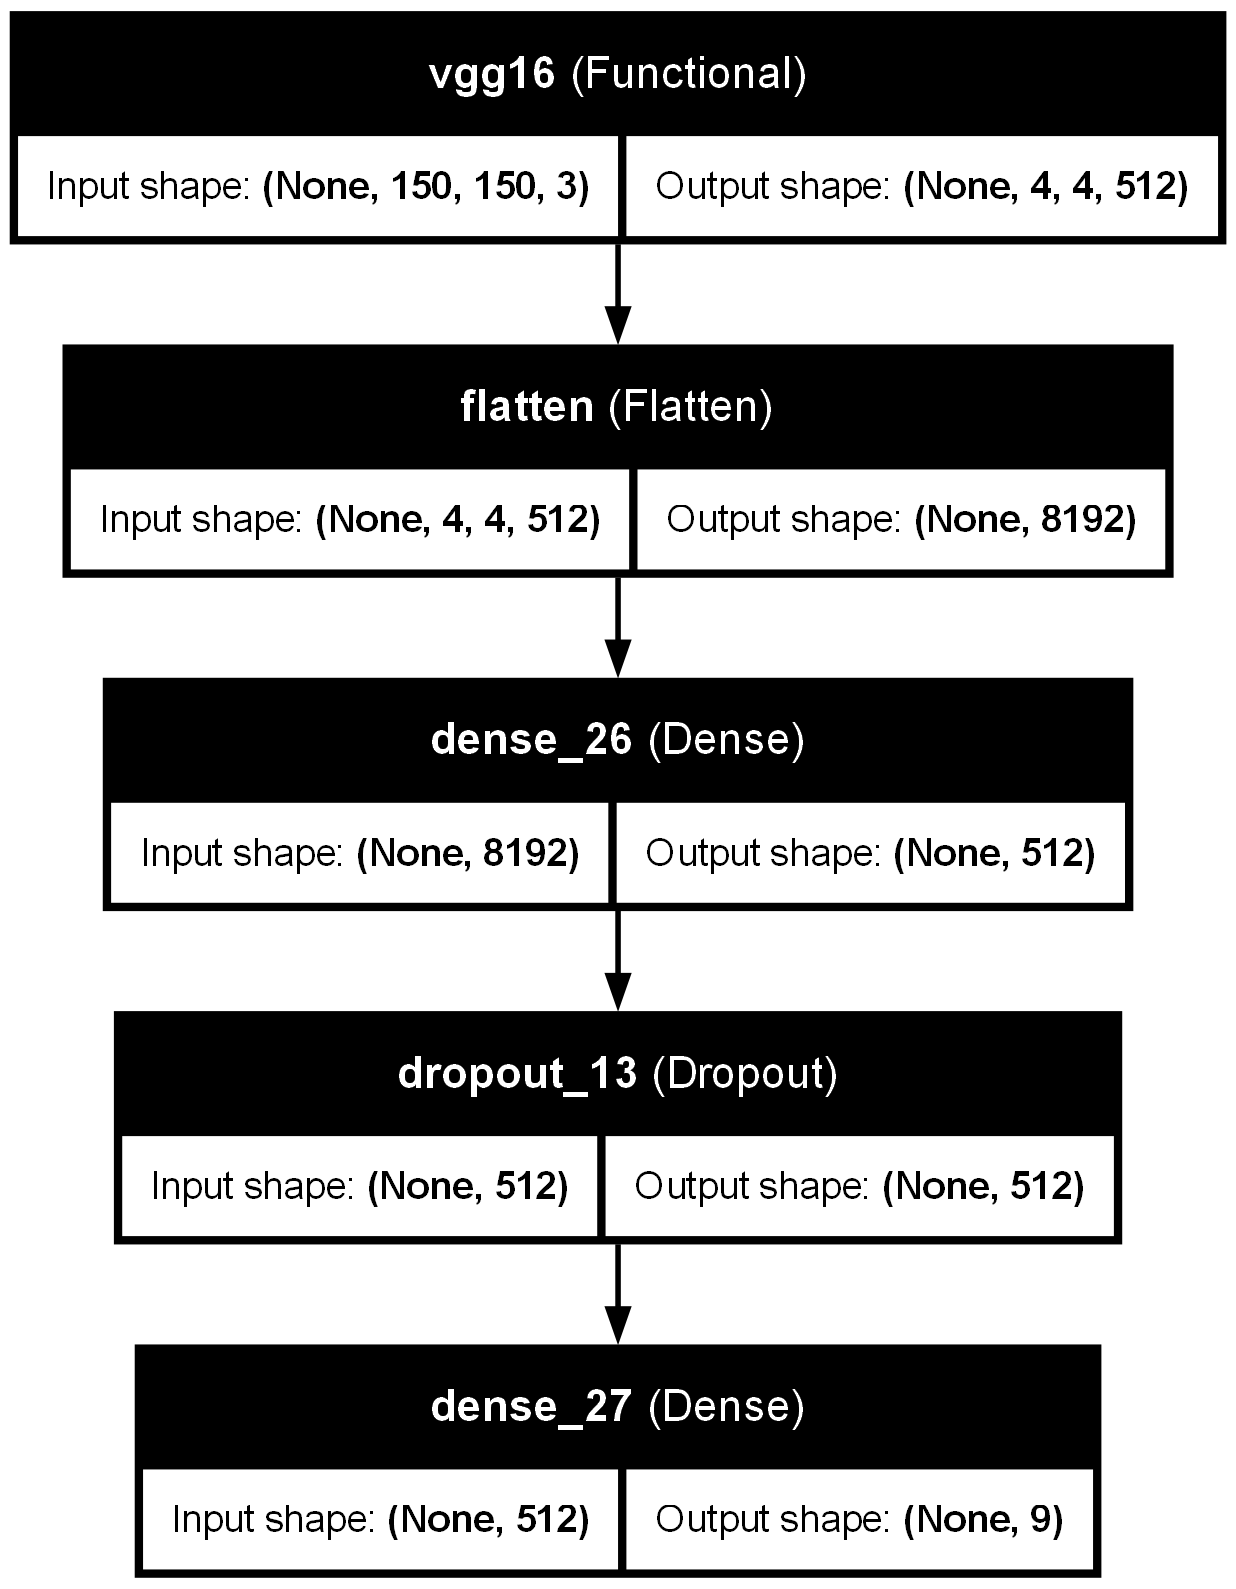

In [3]:
from keras.models import load_model
from tensorflow.keras.utils import plot_model
import pydot
import pydotplus
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz-12.1.2-win64\bin"


# Load the model from the H5 file
loaded_model = load_model('model_vgg.h5')

plot_model(loaded_model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)




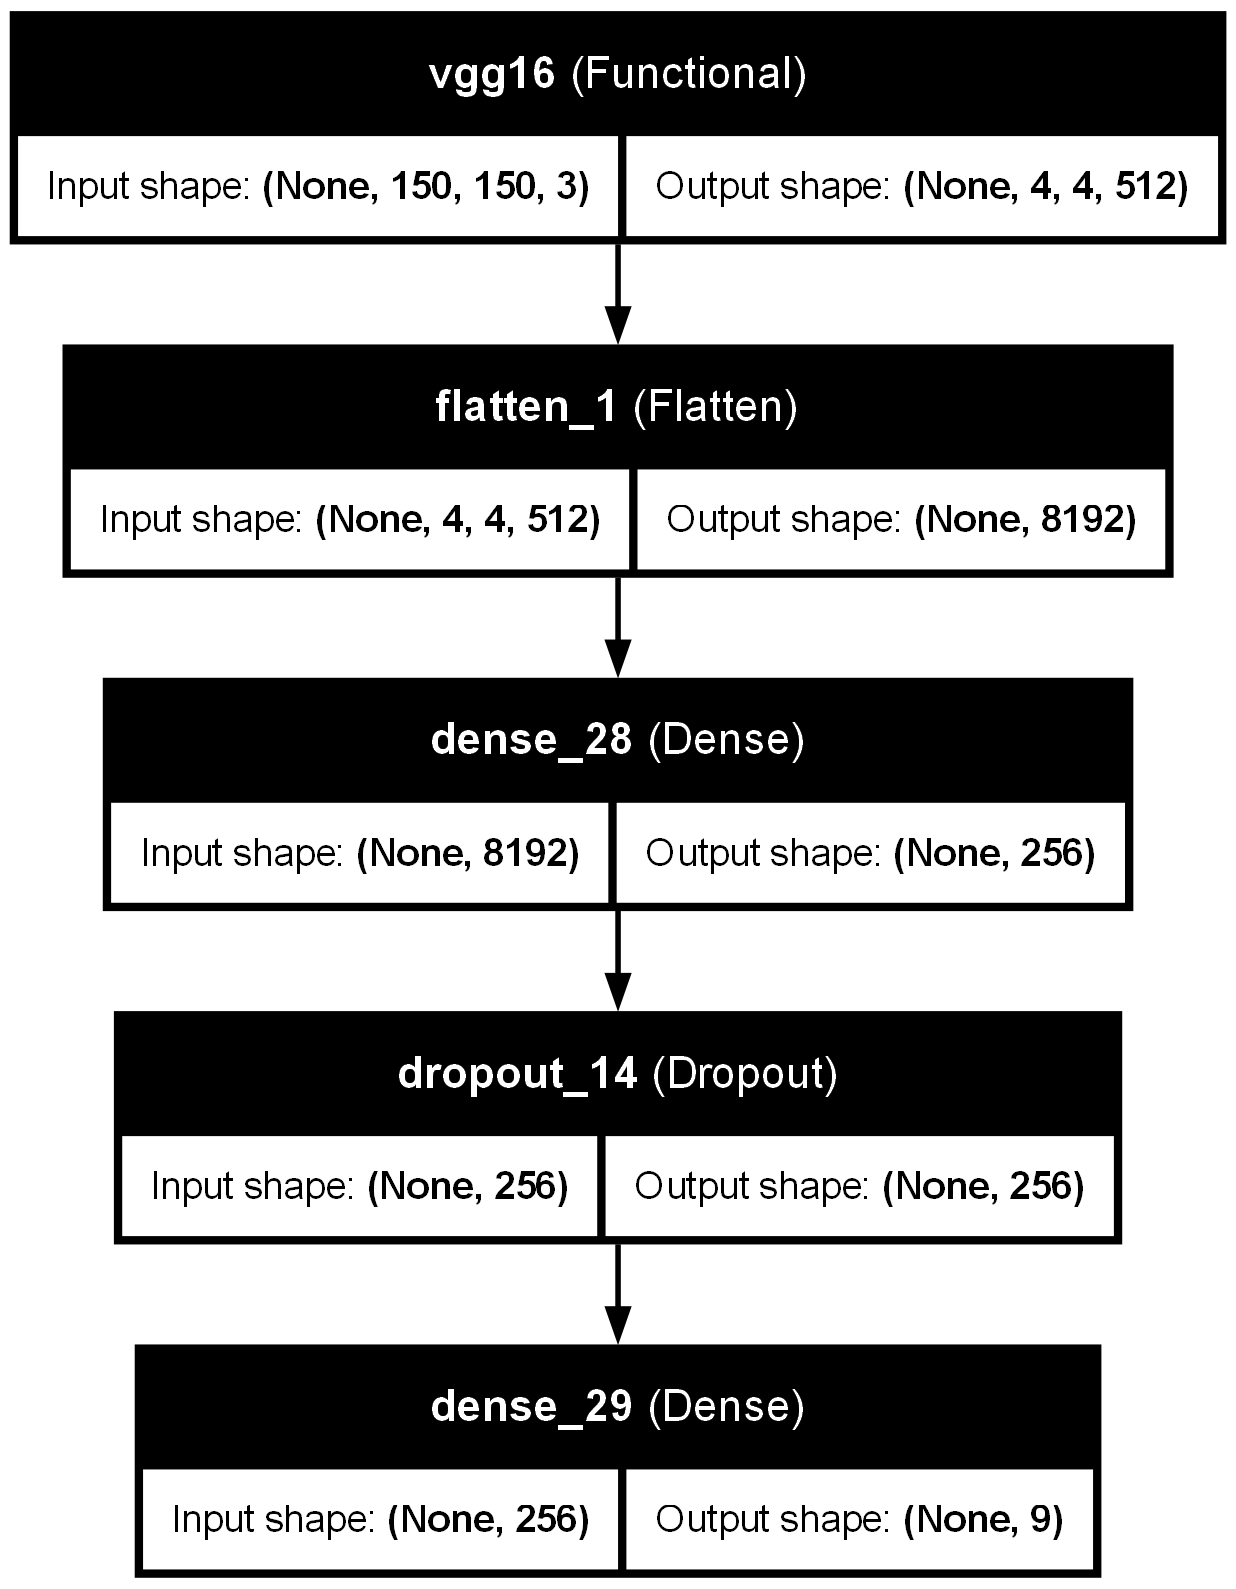

In [4]:
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz-12.1.2-win64\bin"


# Load the model from the H5 file
loaded_model = load_model('model_vgg2.h5')

plot_model(loaded_model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

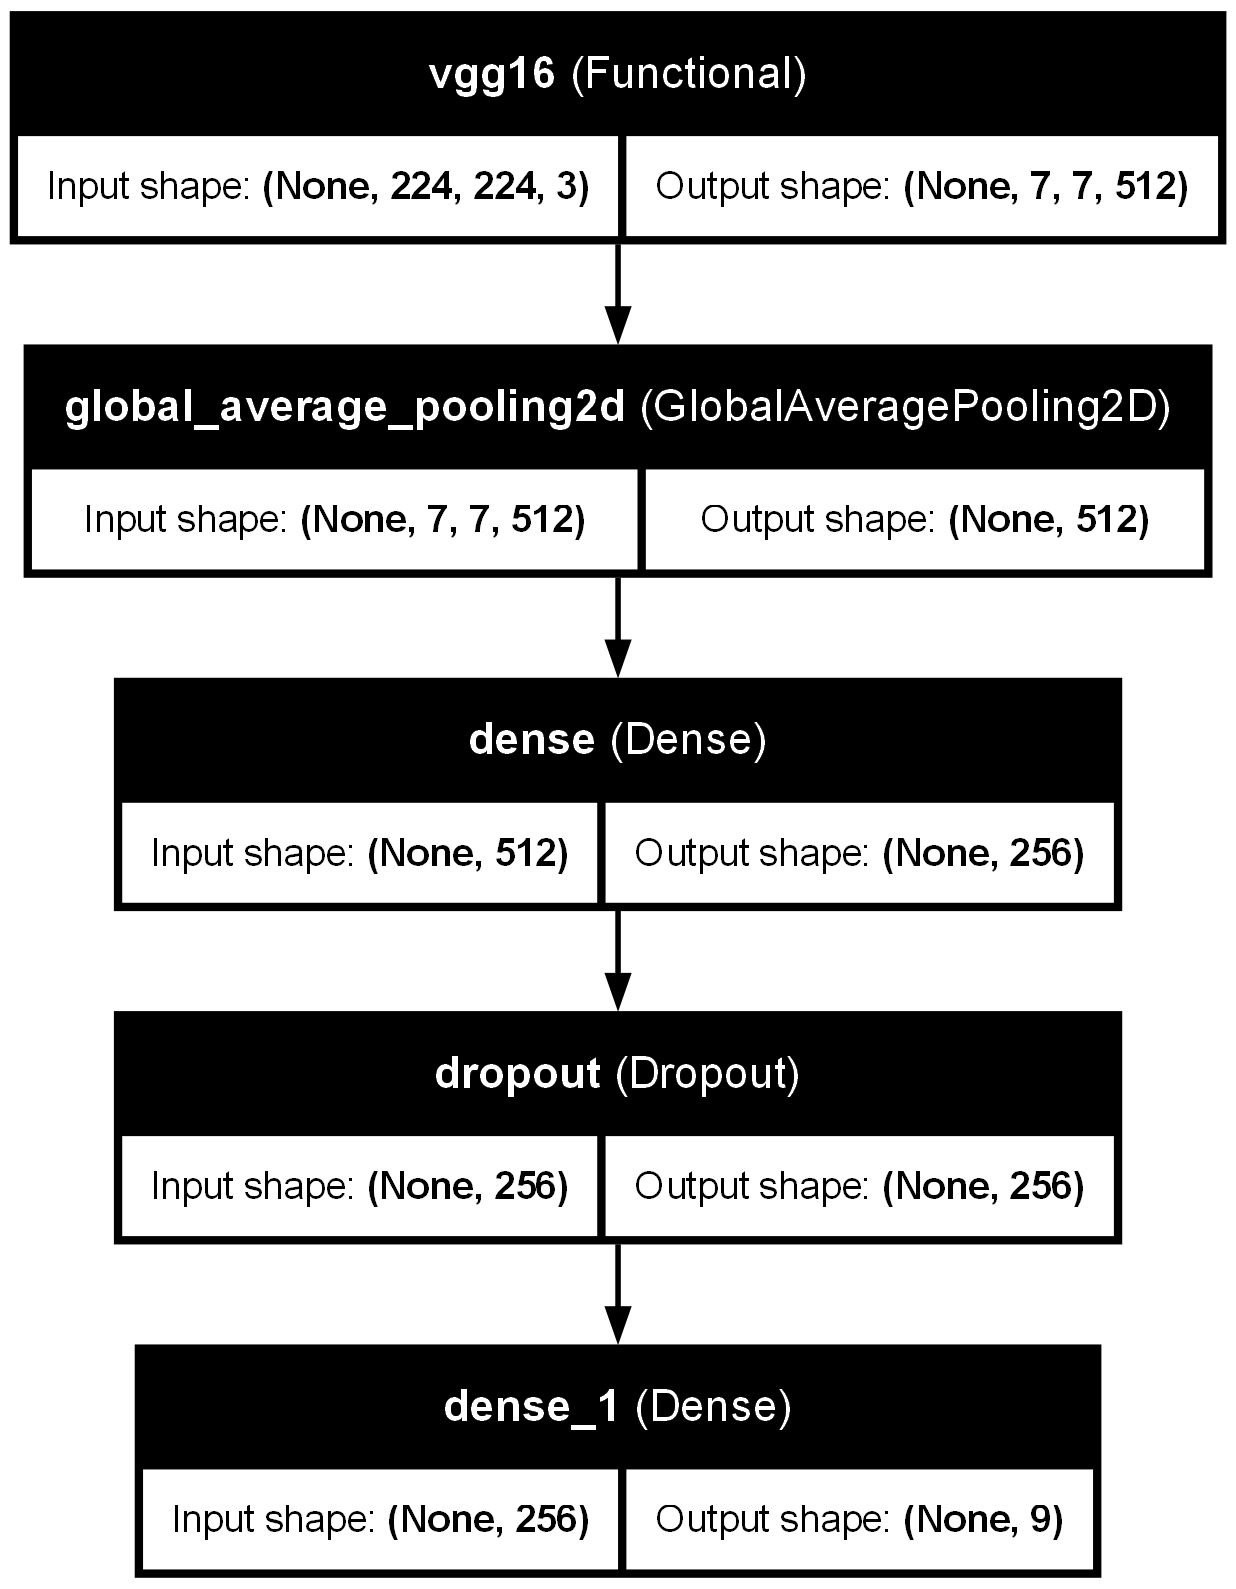

In [5]:
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz-12.1.2-win64\bin"


# Load the model from the H5 file
loaded_model = load_model('model_vgg3.h5')

plot_model(loaded_model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)